In [3]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 71 (delta 25), reused 54 (delta 14), pack-reused 0
Receiving objects: 100% (71/71), 169.42 KiB | 1.20 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [4]:
cd lag-llama

/content/lag-llama


In [5]:
pip install -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 69.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.8/257.8 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10

In [6]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
downloading https://huggingface.co/time-series-foundation-models/Lag-Llama/resolve/main/lag-llama.ckpt to /root/.cache/huggingface/hub/tmpzkx3_8b1
lag-llama.ckpt: 100% 29.5M/29.5M [00:00<00:00, 157MB/s]
/content/lag-llama/lag-llama.ckpt


In [7]:
from itertools import islice
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from lag_llama.gluon.estimator import LagLlamaEstimator

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [8]:
dataset = get_dataset("australian_electricity_demand")

backtest_dataset = dataset.test
prediction_length = dataset.metadata.prediction_length
context_length = 3 * prediction_length

Download australian_electricity_demand_dataset.zip:: 5.51MB [00:03, 1.81MB/s]
creating json files: 100%|██████████| 5/5 [00:00<00:00, 7642.68it/s]


In [9]:
ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cuda:0'))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

In [10]:
estimator = LagLlamaEstimator(
    ckpt_path="lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,

    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
)

lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

In [11]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=predictor,
)

In [12]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [13]:
evaluator = Evaluator()

In [14]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 5it [00:00, 125.15it/s]


In [15]:
agg_metrics

{'MSE': 231911.26825520833,
 'abs_error': 74193.04113769531,
 'abs_target_sum': 998149.748046875,
 'abs_target_mean': 3327.165826822916,
 'seasonal_error': 238.53778569914635,
 'MASE': 1.192892649555502,
 'MAPE': 0.11364948908487955,
 'sMAPE': 0.10302517573038736,
 'MSIS': 28.371900660043536,
 'QuantileLoss[0.1]': 100069.3451690674,
 'Coverage[0.1]': 0.06,
 'QuantileLoss[0.2]': 108876.57944335938,
 'Coverage[0.2]': 0.11333333333333333,
 'QuantileLoss[0.3]': 99241.29347229004,
 'Coverage[0.3]': 0.23666666666666666,
 'QuantileLoss[0.4]': 82561.75391845703,
 'Coverage[0.4]': 0.35,
 'QuantileLoss[0.5]': 74193.04057312012,
 'Coverage[0.5]': 0.5733333333333334,
 'QuantileLoss[0.6]': 74642.09739990234,
 'Coverage[0.6]': 0.7733333333333333,
 'QuantileLoss[0.7]': 78098.61605834964,
 'Coverage[0.7]': 0.8733333333333333,
 'QuantileLoss[0.8]': 78308.31489257811,
 'Coverage[0.8]': 0.9666666666666666,
 'QuantileLoss[0.9]': 71746.93056030272,
 'Coverage[0.9]': 1.0,
 'RMSE': 481.57166471378724,
 'NRMS

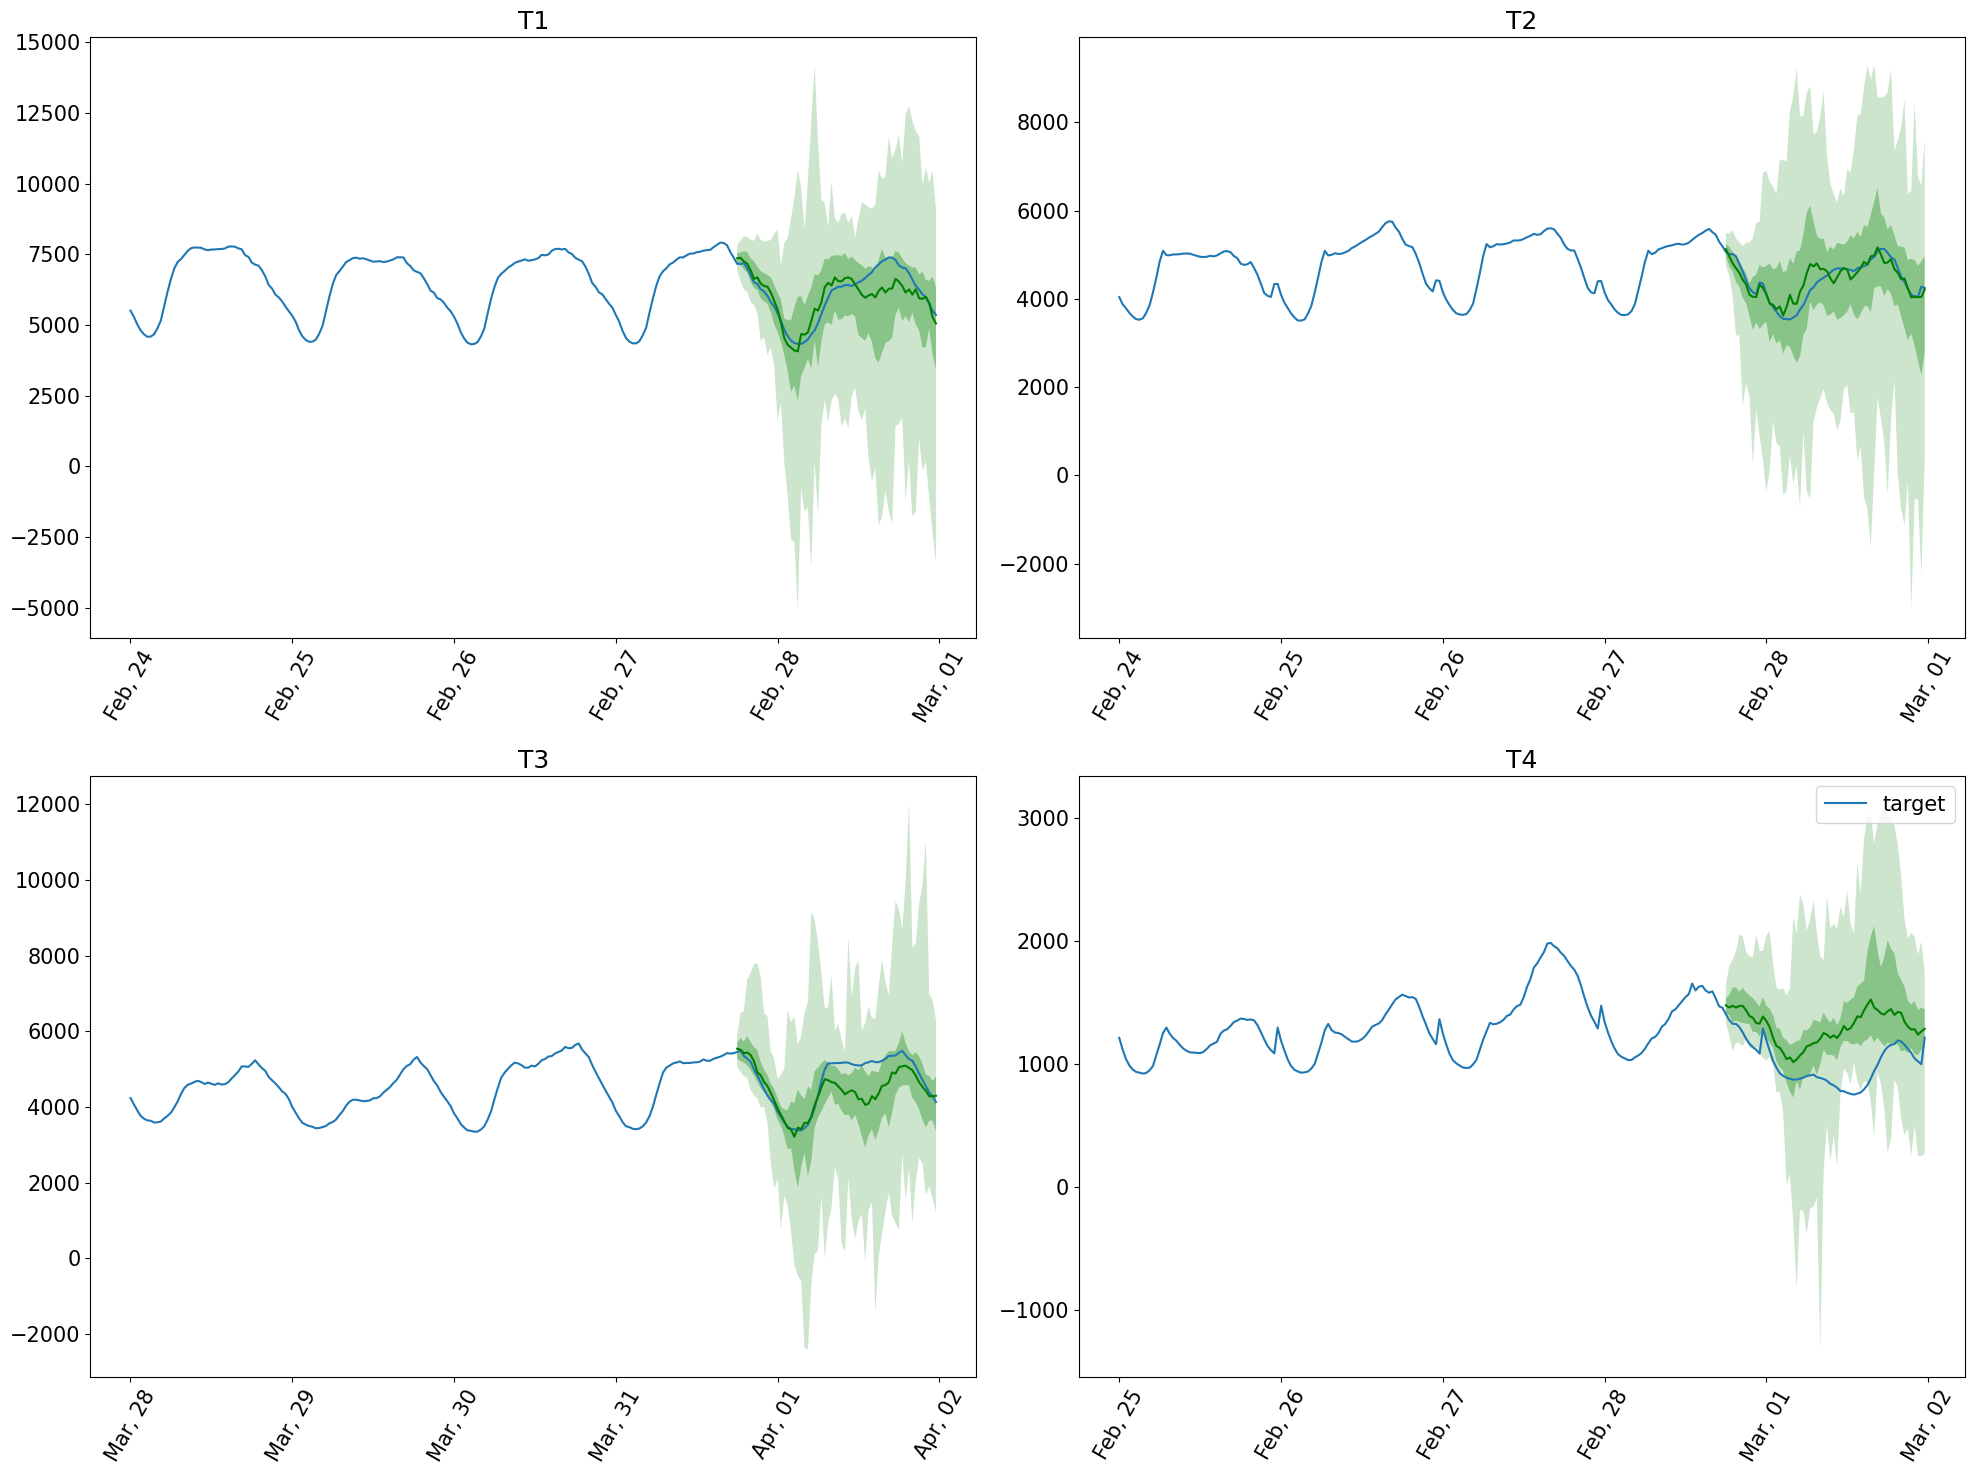

In [16]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 4):
    ax = plt.subplot(2, 2, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [17]:
from gluonts.torch import TemporalFusionTransformerEstimator, DeepAREstimator

tft_estimator = TemporalFusionTransformerEstimator(
    prediction_length=prediction_length,
    context_length=context_length,
    freq="30min",
    trainer_kwargs={"max_epochs": 5}
)

deepar_estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=context_length,
    freq="30min",
    trainer_kwargs={"max_epochs": 5}
)


In [18]:
tft_predictor = tft_estimator.train(dataset.train)
deepar_predictor = deepar_estimator.train(dataset.train)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                           | Params | In sizes | Out sizes 
---------------------------------------------------------------------------------
0 | model | TemporalFusionTransformerModel | 132 K  | ?        | [1, 9, 60]
---------------------------------------------------------------------------------
132 K     Tr

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 3402.72852 (best 3402.72852), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 2287.75781 (best 2287.75781), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached 2147.22095 (best 2147.22095), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached 2080.50269 (best 2080.50269), saving model to '/content/lag-llama/lightning_logs/version_0/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached 2030.43994 (

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 8.41947 (best 8.41947), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 7.10557 (best 7.10557), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 150: 'train_loss' reached 6.71474 (best 6.71474), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 200: 'train_loss' reached 6.62089 (best 6.62089), saving model to '/content/lag-llama/lightning_logs/version_1/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 250: 'train_loss' reached 6.43715 (best 6.43715), saving model

In [19]:
tft_forecast_it, tft_ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=tft_predictor,
)

deepar_forecast_it, deepar_ts_it = make_evaluation_predictions(
    dataset=backtest_dataset,
    predictor=deepar_predictor,
)

In [20]:
tft_forecasts = list(tft_forecast_it)
tft_tss = list(tft_ts_it)

deepar_forecasts = list(deepar_forecast_it)
deepar_tss = list(deepar_ts_it)

In [21]:
tft_agg_metrics, tft_ts_metrics = evaluator(iter(tft_tss), iter(tft_forecasts))
deepar_agg_metrics, deepar_ts_metrics = evaluator(iter(deepar_tss), iter(deepar_forecasts))

Running evaluation: 5it [00:00, 118.32it/s]
Running evaluation: 5it [00:00, 149.41it/s]


In [22]:
print(f'''

Lag-LlamaL: {agg_metrics['RMSE']}
TFT: {tft_agg_metrics['RMSE']}
DeepAR: {deepar_agg_metrics['RMSE']}

''')



Lag-LlamaL: 481.57166471378724
TFT: 272.6146748388648
DeepAR: 445.51344081184624
      

